In [1]:
import serial
import time
import pandas as pd
import os


# 설정 변수
"""수집 전 매번 offset 확인 필수"""
port = "COM4"  # 아두이노가 연결된 포트 (리눅스/Mac의 경우 "/dev/ttyUSB0" 등)
baud_rate = 115200  # 아두이노 시리얼 통신 속도
experiment_count = 1  # 총 실험 반복 횟수
experiment_duration = 3  # 실험 지속 시간 (초)
interval = 0.005  # 데이터 수집 간격 (초)

late_day = 30 #달걀상온경과일. 실험마다 수정 필요.
exp_num = 1 #실험(달걀) 번호. 실험마다 수정 필요.


csv_filename = (f"data/demon/exp_{exp_num}_DAY{late_day}/DAY{late_day}_exp")  # 저장할 파일 이름 (실험 번호가 추가됨)

# 폴더가 존재하지 않으면 생성
os.makedirs(os.path.dirname(csv_filename), exist_ok=True)


iteration = int(experiment_duration / interval)  # 각 실험에서 수집할 데이터 개수

def clearInput():
    while( ser.in_waiting > 0 ):
        treshline = ser.readline()
    

# 시리얼 포트 열기
ser = serial.Serial(port, baud_rate, timeout=1)
time.sleep(3)  # 아두이노 초기화 대기

for exp in range(1, experiment_count + 1):
    
    time.sleep(1)  # 실험 간 대기 시간 (필요에 따라 조정)
    clearInput()
    
    
    print(f"exp {exp} start...")
    
    ser.write(b'8')  # 아두이노에서 "END" 신호를 인식하도록 설정
    # print("vibration end")
    
    clearInput()
    data_list = []
    start_time = time.time()

    for i in range(iteration):
        if ser.in_waiting > 0:
            try:
                line = ser.readline().decode("utf-8", errors="ignore").strip()
            except UnicodeDecodeError:
                print("decoding error appeared. ignore it.")
                continue

            values = line.split(",")
            if len(values) == 3:  # 예상한 데이터 개수와 일치하는 경우만 저장
                try:
                    data_list.append([float(v) for v in values])
                except ValueError:
                    pass  # 변환 불가능한 데이터 무시
        time.sleep(interval)  # 다음 데이터 수집까지 대기

    # 데이터 저장
    df = pd.DataFrame(data_list, columns=["gyro_x", "gyro_y", "gyro_z"])
    filename = f"{csv_filename}{exp}.csv"
    df.to_csv(filename, index=False)
    print(f"exp {exp} data successfully collected: {filename}")

    

# 시리얼 포트 닫기
ser.close()
print("all experiments completed.")


exp 1 start...
exp 1 data successfully collected: data/demon/exp_1_DAY30/DAY30_exp1.csv
all experiments completed.


In [2]:
from data_utils import *

import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from model import InceptionNetwork
import matplotlib.pyplot  as plt
import csv

In [3]:
global_min = torch.tensor([-710., -501., -708.])
global_max = torch.tensor([670., 544., 655.])
regression = True
ybatchNormalize = True
y_mean = 18.33333396911621
y_std = 9.783748626708984

In [6]:
data_paths_test = [
    "data/demon/exp_1_DAY30", ##이름 확인
    #"data/demon/exp_1_DAY3"
    ]
day_values_test = ["30"]#날짜 확인

folder2label_test = {folder: int(folder.split("DAY")[-1]) for folder in data_paths_test}
label2name_test = {int(day_values_test[idx]): day for idx, day in enumerate(day_values_test)}

dataset_test = PaddedTimeSeriesDataset(data_paths_test, folder2label_test, global_min = global_min, global_max = global_max, regression=regression)  # 여러 폴더 지정 가능
dataloader_test = DataLoader(dataset_test,  batch_size=1, shuffle=True, collate_fn=collate_fn_regression)

print(folder2label_test)
print(label2name_test)

{'data/demon/exp_1_DAY30': 30}
{30: '30'}


Using device: cpu
cpu
./models/model0513_3/model.pt	device: cpu
Predicted: 30.106714248657227
Ground truth: [30.0]
Test MSE: 0.0114
[30.106714248657227] [30.0]


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_1568\2094601401.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torc

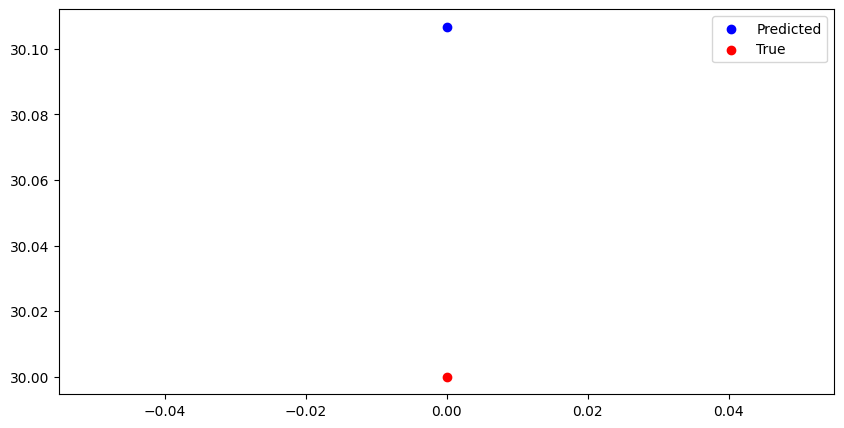

In [7]:
def test_model(model, dataloader, print_prediction=False):
    print("device:", device)
    model = model.to(device)
    model.eval()
    predictions = []
    truths = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch).squeeze()  # 예: (B, 1) → (B,)
            if ybatchNormalize:
                #역정규화
                outputs = outputs * y_std + y_mean
            predictions.extend([outputs.cpu().tolist()])
            truths.extend(y_batch.cpu().tolist())
            if print_prediction:
                print("Predicted:", outputs.cpu().tolist())
                print("Ground truth:", y_batch.cpu().tolist())

    # 예: MSE 계산
    mse = sum((p - t) ** 2 for p, t in zip(predictions, truths)) / len(truths)
    print(f"Test MSE: {mse:.4f}")
    return predictions, truths


trained_model_paths = [
    "./models/model0513_3/model.pt"
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for model_path in trained_model_paths:
    print(device)
    model = torch.load(model_path, map_location=torch.device('cpu'))
        
    print(model_path, end='\t')
    p,r = test_model(model, dataloader_test, print_prediction=True)
    print(p,r)
    xAxis = range(len(p))
    plt.figure(figsize=(10, 5))
    plt.scatter(xAxis, p, color='blue', label='Predicted')
    plt.scatter(xAxis, r,color='red', label='True')
    plt.legend()
    plt.plot()
    plt.show()